# Homograph Study

A great innovation in LLM from first generation language models like GloVe and Word2Vec is that words with multiple meanings can have different representations with in a sentence.  For example a word like "bat" might mean a baseball bat or a flying mammal.

A **homograph** is the technical term for a word with the same spelling but contains multiple meanings.

Lets example we can look at the following GPT-4 embeddings for "bat", "baseball bat" and "flying bat"

### Imports

In [16]:
import pprint
import tqdm
from pydantic import BaseModel, Field

from promptedgraphs.config import Config
from promptedgraphs.ideation import brainstorm
from promptedgraphs.vis import render_entities, get_colors
from itertools import combinations
from sklearn.metrics.pairwise import cosine_distances
from promptedgraphs.models import EntityReference
import re

## Data Model

In [17]:
class Homographs(BaseModel):
    """A homograph is a word with multiple meanings, we show here the word, and two sentences with multiple uses of the word.
    """
    homograph: str = Field(title="A word that is a homograph", example=['bat'])
    example_sentence1: str = Field(title="An example of the homograph used in a unique context", example=['He took a swing with the baseball bat.'] )
    example_sentence2: str = Field(title="A second example of the homograph used in a different context", example=['The bat flew out of the cave at dusk.'])
    context1: str = Field(title="A one word description of the homophone's context in example_sentence1", examples=['sports'])
    context2: str = Field(title="A one word description of the homophone's context in example_sentence2", examples=['animal'])

    def __repr__(self):
        return f"{self.homograph}:\n * {self.context1}: {self.example_sentence1}\n * {self.context2}: {self.example_sentence2}\n"

## Brainstorm Homographs (GPT 3.5 turbo generated examples)

In [18]:
ideas = {}

In [19]:
ittr = tqdm.tqdm()
async for idea in brainstorm(
    text=Homographs.__doc__, 
    output_type=list[Homographs], 
    config=Config(),
    n=40,
    max_workers=2,
    temperature=0.5
):
    if idea.homograph not in ideas:
        ideas[idea.homograph] = idea
        ittr.update(1)
        ittr.set_description(idea.homograph)

ideas = sorted(ideas.values(), key=lambda x: x.homograph)
    # render_entities(f"We help {idea.adj} {idea.target_audience} {idea.action} so they can {idea.benefit}", idea)

wind: : 11it [03:18, 18.04s/it]
bark: : 13it [00:22,  1.99s/it]   

In [20]:
ideas[0]

bark:
 * animal: The dog's bark echoed through the neighborhood.
 * action: She will bark the tree to mark the trail.

### Display Results

In [21]:
docs = [(idea.example_sentence1, EntityReference(
                    start=match.start(),
                    end=match.end(),
                    text=idea.homograph,
                    label=idea.context1,
                )) for i, idea in enumerate(ideas) for match in re.finditer(idea.homograph.lower(), idea.example_sentence1.lower())]
docs += [(idea.example_sentence2, EntityReference(
                    start=match.start(),
                    end=match.end(),
                    text=idea.homograph,
                    label=idea.context2,
                )) for i, idea in enumerate(ideas) for match in re.finditer(idea.homograph.lower(), idea.example_sentence2.lower())]
docs.sort(key=lambda x: x[1].text)
fields = sorted({doc[1].label for doc in docs})
colors = get_colors(fields)

for doc in docs:
    render_entities(doc[0], ents=[doc[1]], colors=colors)

### Exploration of Embeddings
Lets take a look at the embeddings for each of these homograph.  I would assume that each of the homographs would be located "between" the embeddings of the various statements, bet lets see"

The first step is to calculate the distances between them to see if they behave 

In [23]:
from openai import OpenAI
import tqdm
client = OpenAI()

def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

embeddings = {}
for i, idea in tqdm.tqdm(enumerate(ideas), total=len(ideas)):
    embeddings[idea.homograph] = get_embedding(idea.homograph, model='text-embedding-3-small')
    embeddings[idea.example_sentence1] = get_embedding(idea.example_sentence1, model='text-embedding-3-small')
    embeddings[idea.example_sentence2] = get_embedding(idea.example_sentence2, model='text-embedding-3-small')
    embeddings[idea.context1] = get_embedding(idea.context1, model='text-embedding-3-small')
    embeddings[idea.context2] = get_embedding(idea.context2, model='text-embedding-3-small')


100%|█████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:34<00:00,  2.69s/it]


The dog's bark echoed through the neighborhood. Norm: 1.0000000530450577


<Axes: >

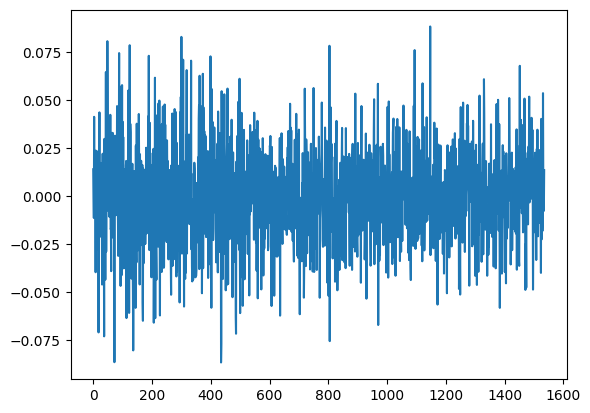

In [34]:
len(embeddings)
import numpy as np
k = list(embeddings.keys())[1]
print(k, 'Norm:', np.dot(embeddings[k],embeddings[k]))

import pandas as pd
pd.Series(embeddings[k], name=k).plot()

## Issues for RAG

How to homographs in our database affect our RAG systems.  Lets say we have a request to generate information about **sound**.

Our vector retrieval system looks for sentences in the database with a close proximity to 'sound'.  Lets look at the top matches:



In [ ]:
for doc in docs:
    render_entities(doc[0], ents=[doc[1]], colors=colors)

In [ ]:
print(ideas[0])

In [ ]:
rag_example_query = ideas[0].context1
rag_example_query
rag_example_embedding = np.array(embeddings[0][4])

print(f"Searching for {rag_example_query}")
pprint.pprint( 
    sorted([(ideas[0].example_sentence1, np.dot(rag_example_embedding, embeddings[0][2])),
    (ideas[0].example_sentence2, np.dot(rag_example_embedding, embeddings[0][3]))
    ]))

In [ ]:

# Function to check the triangle inequality for all combinations of three vectors
def check_triangle_inequality(distances):
    n = len(distances)  # Number of vectors
    results = []  # Store results of checks
    for i, j, k in combinations(range(n), 3):
        # Check triangle inequality for each combination of three vectors
        if distances[i][j] + distances[j][k] >= distances[i][k] and \
           distances[i][k] + distances[k][j] >= distances[i][j] and \
           distances[j][i] + distances[i][k] >= distances[j][k]:
            results.append(((i, j, k), True))
        else:
            results.append(((i, j, k), False))
    return results

In [ ]:
# Check which relations satisfy the triangle inequality
for i,_ in enumerate(embeddings):
    pairwise_distances = cosine_distances(embeddings[i][1:])
    triangle_inequality_results = check_triangle_inequality(pairwise_distances)
    failed_triangles = len([_ for _ in triangle_inequality_results if not _[1]])
    # print(i, failed_triangles)
    if failed_triangles:
        print(ideas[i])
        print(triangle_inequality_results)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

i = 0
pairwise_distances = cosine_distances(embeddings[i][1:])
idea = ideas[i]

# Create a graph from the distance matrix
G = nx.Graph()

# Add nodes
node_names = [
    idea.homograph,
    f"example({idea.context1})",
    f"example({idea.context2})",
    f"{idea.context1}",
    f"{idea.context2}",
]
for name in node_names:
    G.add_node(name)

# Add edges with distances as weights
for i in range(len(pairwise_distances)):
    for j in range(i+1, len(pairwise_distances)):
        # Add edge with distance as weight if not zero
        if pairwise_distances[i][j] > 0:
            G.add_edge(node_names[i], node_names[j], weight=1./pairwise_distances[i][j], distance=pairwise_distances[i][j])

# Position nodes using the spring layout
pos = nx.spring_layout(G)

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, edge_color='k', linewidths=1, font_size=15)

# Draw edge labels corresponding to the distances
edge_labels = {e[0]: f"{e[1]*100:.1f}%" for e in nx.get_edge_attributes(G, 'distance').items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.suptitle('Network Graph of Nodes with Cosine Distances as Edge Lengths')
plt.axis('off')  # Turn off the axis
plt.title(pprint.pformat(idea))
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Reuse the previous graph structure
G_custom_3d = G.copy()

# Generate 3D positions for the nodes (this can be random or structured depending on your preference)
pos_3d = nx.spring_layout(G_custom_3d, dim=3)

# Extract the xyz coordinates from pos_3d for plotting
xyz = np.array([pos_3d[v] for v in sorted(G_custom_3d)])

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot nodes
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c='skyblue', s=100)

# Plot edges
for i, j in G_custom_3d.edges():
    x = np.array((pos_3d[i][0], pos_3d[j][0]))
    y = np.array((pos_3d[i][1], pos_3d[j][1]))
    z = np.array((pos_3d[i][2], pos_3d[j][2]))
    ax.plot(x, y, z, c='gray')

# Annotate node names
for name, (x, y, z) in pos_3d.items():
    ax.text(x, y, z, name, color='black')

ax.set_title('3D Network Graph with Custom Node Names')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


In [ ]:
## T-SNE
from sklearn.manifold import TSNE
import seaborn as sns

# Original embeddings (vectors)
# X = np.array(embeddings[0][1:])
X = np.concatenate([np.array(v[1:]) for v in embeddings], axis=0)

# Create a t-SNE model
tsne = TSNE(n_components=2, random_state=42, perplexity=4)  # Using 2 components for 2D visualization

# Fit and transform the data with t-SNE
X_tsne = tsne.fit_transform(X)

palette = sns.color_palette("bright", len(ideas))

# Plot the t-SNE transformed data
plt.figure(figsize=(12, 9))
k = -1
for i in range(len(X_tsne)):
    if i % 5 == 0:
        k += 1
        idea = ideas[k]
        node_names = [
            idea.homograph,
            f"ex1",
            f"ex2",
            f"c1:{idea.context1}",
            f"c2:{idea.context2}",
        ]
    plt.scatter(X_tsne[i, 0], X_tsne[i, 1], color=palette[k])
    plt.text(X_tsne[i, 0], X_tsne[i, 1], node_names[i % 5], fontdict={'size': 10})

plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.title('t-SNE Visualization of Original Embeddings')
plt.show()

In [ ]:
node_names

# Advanced usage

Positive, examples, negative examples and refining the topic area

## "Work from home dads" - Niche

In [ ]:
niche_ideas = []
async for idea in brainstorm(
    text=BusinessIdea.__doc__ + "\n in the Work from home dads niche", 
    output_type=list[BusinessIdea], 
    config=Config(),
    n=5,
):
    niche_ideas.append(idea)
    render_entities(f"We help {idea.adj} {idea.target_audience} {idea.action} so they can {idea.benefit}", idea)

### Nudging results with few-shot prompting

In [ ]:
niche_ideas[0]

In [ ]:
niche_ideas[-1]

### More 'family time' results

In [ ]:
new_niche_ideas = []
async for idea in brainstorm(
    text=BusinessIdea.__doc__ + "\n in the Work from home dads niche", 
    output_type=list[BusinessIdea], 
    config=Config(),
    positive_examples=[niche_ideas[0]],
    negative_examples=[niche_ideas[-1]],
    n=5,
):
    new_niche_ideas.append(idea)
    render_entities(f"We help {idea.adj} {idea.target_audience} {idea.action} so they can {idea.benefit}", idea)

## More Career oriented results

In [ ]:
new_niche_ideas = []
async for idea in brainstorm(
    text=BusinessIdea.__doc__ + "\n in the Work from home dads niche", 
    output_type=list[BusinessIdea], 
    config=Config(),
    positive_examples=[niche_ideas[-1]],
    negative_examples=[niche_ideas[0]],
    n=5,
):
    new_niche_ideas.append(idea)
    render_entities(f"We help {idea.adj} {idea.target_audience} {idea.action} so they can {idea.benefit}", idea)